In [1]:

# ============================================================================
# CELL 1: Install Required Libraries
# ============================================================================
!pip install networkx pandas numpy matplotlib seaborn scikit-learn python-louvain

In [2]:
# ============================================================================
# CELL 2: Import Libraries
# ============================================================================
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import community.community_louvain as community_louvain
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
# ============================================================================
# CELL 3: Download and Load Facebook Dataset
# ============================================================================
# Download the dataset
!wget https://snap.stanford.edu/data/facebook_combined.txt.gz
!gunzip facebook_combined.txt.gz

# Load the edge list
edges_df = pd.read_csv('facebook_combined.txt', sep=' ', header=None, names=['source', 'target'])
print(f"Dataset loaded: {len(edges_df)} edges")
print(edges_df.head())

--2025-12-10 18:34:41--  https://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘facebook_combined.txt.gz’

facebook_combined.t 100%[===================>] 213.45K   490KB/s    in 0.4s    

2025-12-10 18:34:41 (490 KB/s) - ‘facebook_combined.txt.gz’ saved [218576/218576]

Dataset loaded: 88234 edges
   source  target
0       0       1
1       0       2
2       0       3
3       0       4
4       0       5


In [4]:
# ============================================================================
# CELL 4: Build Social Network Graph
# ============================================================================
# Create graph from edge list
G = nx.from_pandas_edgelist(edges_df, 'source', 'target')
print(f"\nGraph Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Graph density: {nx.density(G):.4f}")
print(f"Is connected: {nx.is_connected(G)}")

# Get largest connected component
if not nx.is_connected(G):
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    print(f"\nWorking with largest connected component:")
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")


Graph Statistics:
Number of nodes: 4039
Number of edges: 88234
Graph density: 0.0108
Is connected: True


In [5]:
# ============================================================================
# CELL 5: Compute Graph Metrics
# ============================================================================
print("Computing graph metrics...")

# Degree
degree_dict = dict(G.degree())

# Clustering coefficient
clustering_dict = nx.clustering(G)

# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)

# Closeness centrality
closeness_dict = nx.closeness_centrality(G)

# PageRank
pagerank_dict = nx.pagerank(G)

# Community detection
communities = community_louvain.best_partition(G)

# Create feature dataframe
features_df = pd.DataFrame({
    'node_id': list(G.nodes()),
    'degree': [degree_dict[n] for n in G.nodes()],
    'clustering_coef': [clustering_dict[n] for n in G.nodes()],
    'betweenness': [betweenness_dict[n] for n in G.nodes()],
    'closeness': [closeness_dict[n] for n in G.nodes()],
    'pagerank': [pagerank_dict[n] for n in G.nodes()],
    'community': [communities[n] for n in G.nodes()]
})

print("\nGraph Features Summary:")
print(features_df.describe())

Computing graph metrics...

Graph Features Summary:
           node_id       degree  clustering_coef   betweenness    closeness  \
count  4039.000000  4039.000000      4039.000000  4.039000e+03  4039.000000   
mean   2019.000000    43.691013         0.605547  6.669574e-04     0.276168   
std    1166.103197    52.420605         0.214462  1.164634e-02     0.036124   
min       0.000000     1.000000         0.000000  0.000000e+00     0.178255   
25%    1009.500000    11.000000         0.466667  3.997507e-07     0.260348   
50%    2019.000000    25.000000         0.600000  2.918300e-06     0.282457   
75%    3028.500000    57.000000         0.752381  1.515292e-05     0.315001   
max    4038.000000  1045.000000         1.000000  4.805181e-01     0.459699   

          pagerank    community  
count  4039.000000  4039.000000  
mean      0.000248     6.487497  
std       0.000259     4.999483  
min       0.000042     0.000000  
25%       0.000141     3.000000  
50%       0.000219     5.000000 

In [6]:
# ============================================================================
# CELL 6: Simulate Bot Labels
# ============================================================================
# Since the dataset doesn't have bot labels, we'll simulate them
# We'll mark nodes with unusual patterns as "bots"
np.random.seed(42)

# Define bot criteria: high degree, low clustering coefficient
threshold_degree = features_df['degree'].quantile(0.85)
threshold_clustering = features_df['clustering_coef'].quantile(0.30)

# Mark potential bots
features_df['is_bot'] = (
    (features_df['degree'] > threshold_degree) &
    (features_df['clustering_coef'] < threshold_clustering)
).astype(int)

# Add some random noise
noise_indices = np.random.choice(features_df.index, size=int(0.05 * len(features_df)), replace=False)
features_df.loc[noise_indices, 'is_bot'] = np.random.choice([0, 1], size=len(noise_indices))

print(f"\nBot Distribution:")
print(features_df['is_bot'].value_counts())
print(f"Bot percentage: {features_df['is_bot'].mean()*100:.2f}%")


Bot Distribution:
is_bot
0    3784
1     255
Name: count, dtype: int64
Bot percentage: 6.31%


In [7]:
# ============================================================================
# CELL 7: Baseline Bot Detection Model
# ============================================================================
# Prepare features and labels
X = features_df[['degree', 'clustering_coef', 'betweenness', 'closeness', 'pagerank']]
y = features_df['is_bot']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train baseline model
baseline_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
baseline_model.fit(X_train, y_train)

# Evaluate baseline
y_pred_baseline = baseline_model.predict(X_test)

print("=" * 60)
print("BASELINE MODEL PERFORMANCE (No Attack)")
print("=" * 60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_baseline):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_baseline):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

# Store baseline metrics
baseline_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_baseline),
    'precision': precision_score(y_test, y_pred_baseline),
    'recall': recall_score(y_test, y_pred_baseline),
    'f1': f1_score(y_test, y_pred_baseline)
}


BASELINE MODEL PERFORMANCE (No Attack)

Accuracy: 0.9711
Precision: 0.9773
Recall: 0.5584
F1-Score: 0.7107

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1135
           1       0.98      0.56      0.71        77

    accuracy                           0.97      1212
   macro avg       0.97      0.78      0.85      1212
weighted avg       0.97      0.97      0.97      1212



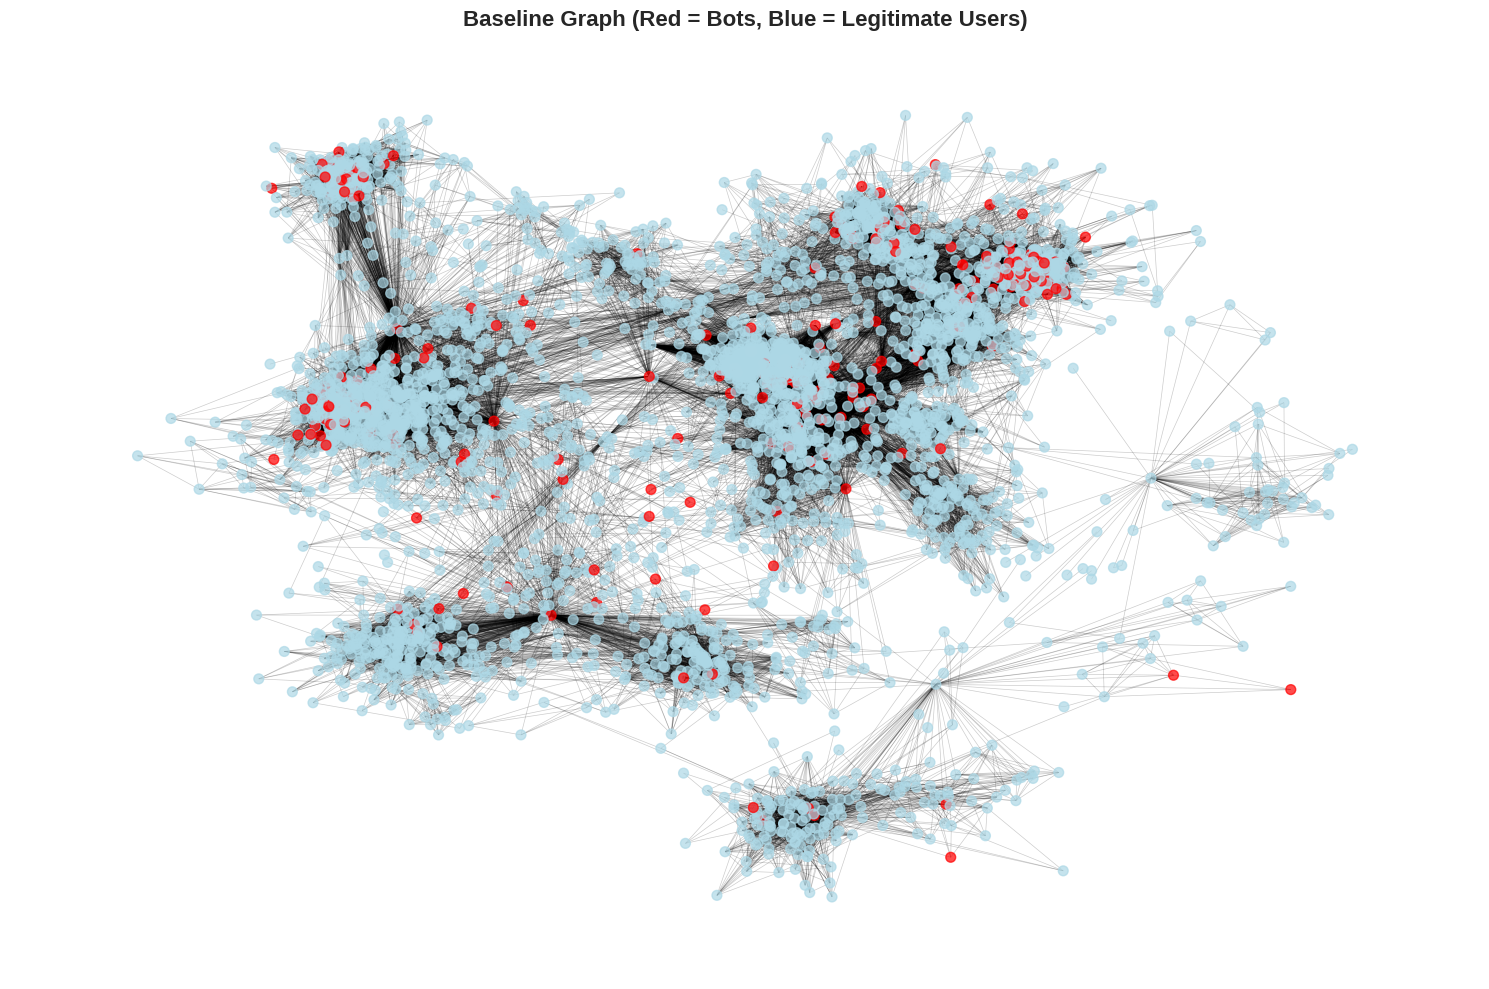

In [48]:
# ============================================================================
# CELL 8: Visualize Baseline Graph
# ============================================================================
# Sample nodes for visualization (full graph is too large)
sample_size = 4039
sampled_nodes = np.random.choice(list(G.nodes()), size=min(sample_size, G.number_of_nodes()), replace=False)
G_sample = G.subgraph(sampled_nodes).copy()

# Get colors based on bot status
node_colors = ['red' if features_df[features_df['node_id']==n]['is_bot'].values[0] == 1
               else 'lightblue' for n in G_sample.nodes()]

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G_sample, k=0.5, iterations=50, seed=42)
nx.draw_networkx_nodes(G_sample, pos, node_color=node_colors, node_size=50, alpha=0.7)
nx.draw_networkx_edges(G_sample, pos, alpha=0.2, width=0.5)
plt.title("Baseline Graph (Red = Bots, Blue = Legitimate Users)", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('baseline_graph.png', dpi=300, bbox_inches='tight')
plt.show()


APPLYING ADVERSARIAL STRUCTURAL EVASION ATTACK (REDUCE PERFORMANCE)

Attacking 50 bot nodes to reduce detection performance...
Removed 112 edges from bot nodes
Graph edges before: 88234, after: 88122


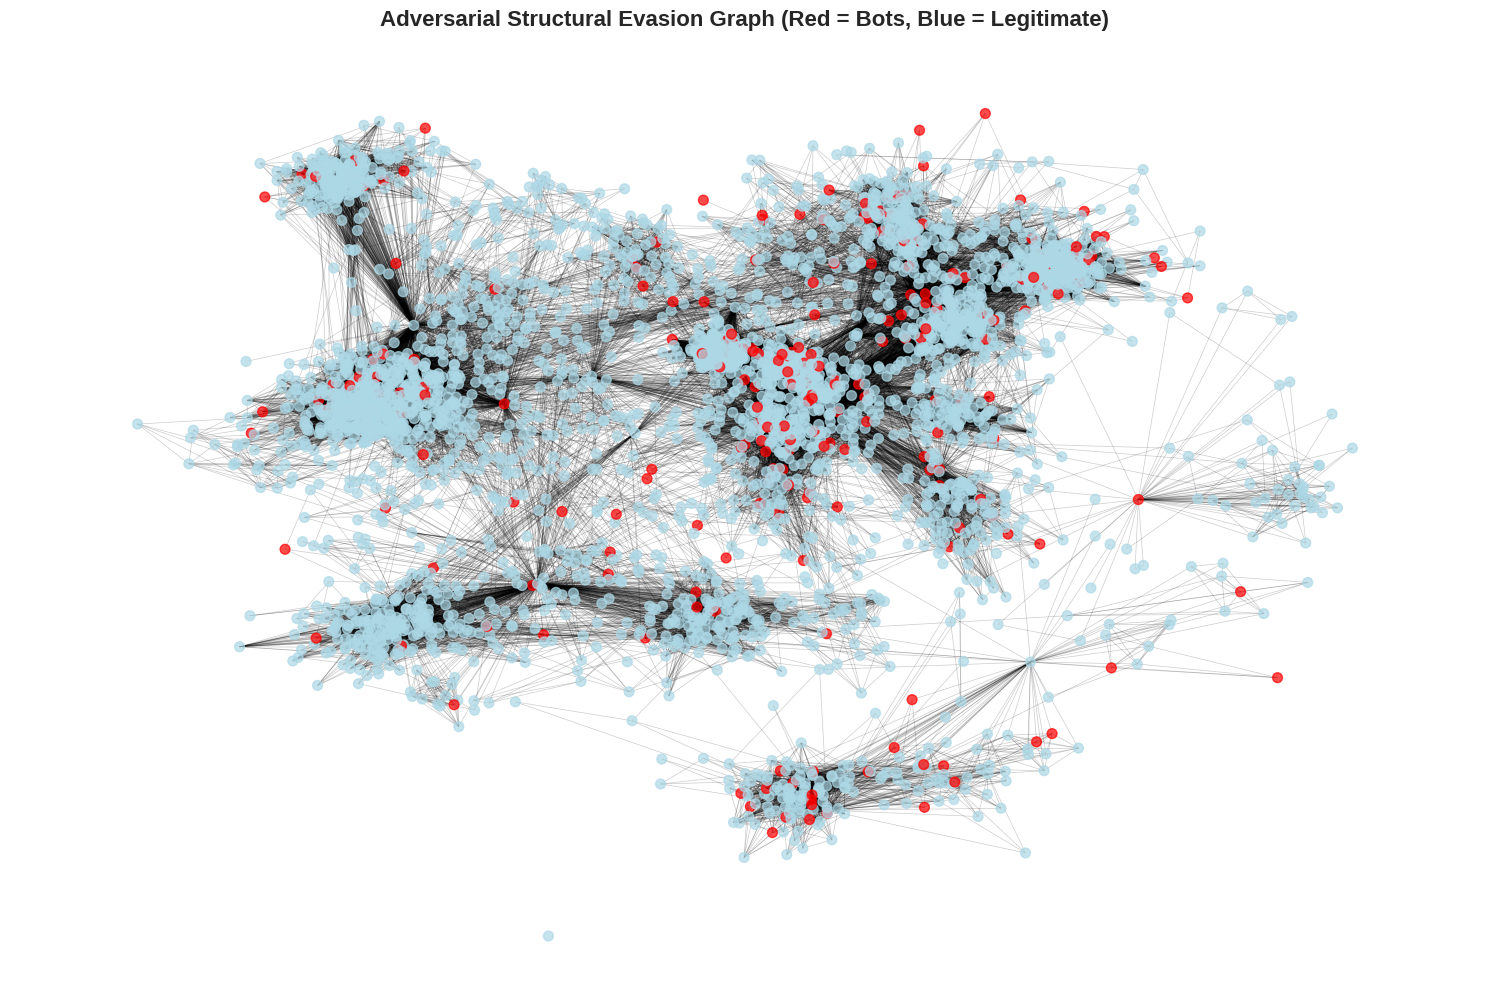

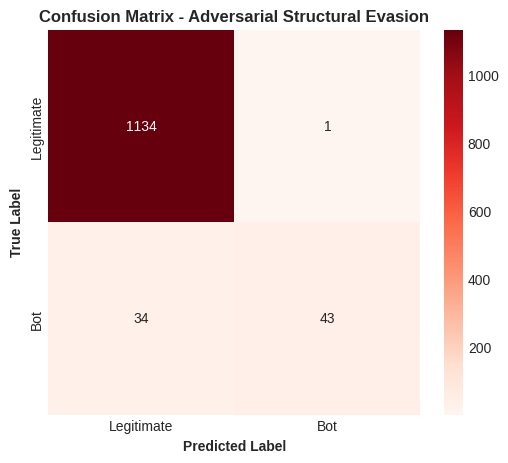

PERFORMANCE AFTER ADVERSARIAL STRUCTURAL EVASION ATTACK
Accuracy: 0.9711
Precision: 0.9773
Recall: 0.5584
F1-Score: 0.7107


In [47]:
# ============================================================================
# CELL 9b: Adversarial Structural Evasion Attack (Performance-Reducing)
# ============================================================================

print("\n" + "=" * 60)
print("APPLYING ADVERSARIAL STRUCTURAL EVASION ATTACK (REDUCE PERFORMANCE)")
print("=" * 60)

# Copy graph for adversarial evasion
G_adv_evasion = G.copy()

# Select bot nodes
bot_nodes = features_df[features_df['is_bot'] == 1]['node_id'].values
num_bots_to_attack = min(50, len(bot_nodes))
attacked_bots = np.random.choice(bot_nodes, size=num_bots_to_attack, replace=False)

print(f"\nAttacking {num_bots_to_attack} bot nodes to reduce detection performance...")

# Adversarial evasion: Disconnect bots from high-degree or high-clustering nodes
# Strategy: Remove edges that help bots appear central
edges_removed = 0
for bot in attacked_bots:
    neighbors = list(G_adv_evasion.neighbors(bot))
    if len(neighbors) > 0:
        # Remove 1-3 edges randomly
        num_remove = min(np.random.randint(1, 4), len(neighbors))
        targets = np.random.choice(neighbors, size=num_remove, replace=False)
        for target in targets:
            G_adv_evasion.remove_edge(bot, target)
            edges_removed += 1

print(f"Removed {edges_removed} edges from bot nodes")
print(f"Graph edges before: {G.number_of_edges()}, after: {G_adv_evasion.number_of_edges()}")

# ============================================================================
# Visualization of the adversarial evasion graph
# ============================================================================

sample_size = 4039  # Sample for visualization
all_nodes = list(G_adv_evasion.nodes())
sample_nodes = np.random.choice(all_nodes, size=min(sample_size, len(all_nodes)), replace=False)
G_sample_adv = G_adv_evasion.subgraph(sample_nodes).copy()

node_colors = []
for n in G_sample_adv.nodes():
    is_bot = features_df.loc[n, 'is_bot']
    node_colors.append('red' if is_bot == 1 else 'lightblue')  # Red = bots, Blue = legitimate

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G_sample_adv, k=0.5, iterations=50, seed=42)
nx.draw_networkx_nodes(G_sample_adv, pos, node_color=node_colors, node_size=50, alpha=0.7)
nx.draw_networkx_edges(G_sample_adv, pos, alpha=0.2, width=0.5)
plt.title("Adversarial Structural Evasion Graph (Red = Bots, Blue = Legitimate)", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# ============================================================================
# Feature extraction for adversarial evasion test
# ============================================================================

# Extract features for all nodes (same as before)
X_adv_ev = features_df[['degree', 'clustering_coef', 'betweenness', 'closeness', 'pagerank']]
y_adv_ev = features_df['is_bot']

# Train/test split same as baseline
X_train_adv_ev, X_test_adv_ev, y_train_adv_ev, y_test_adv_ev = train_test_split(
    X_adv_ev, y_adv_ev, test_size=0.3, random_state=42, stratify=y_adv_ev
)

# Train RandomForest on original labels (simulate detector)
adv_evasion_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
adv_evasion_model.fit(X_train_adv_ev, y_train_adv_ev)

# Predict
y_pred_adv_evasion = adv_evasion_model.predict(X_test_adv_ev)

# ============================================================================
# Confusion Matrix
# ============================================================================

cm = confusion_matrix(y_test_adv_ev, y_pred_adv_evasion)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Legitimate', 'Bot'], yticklabels=['Legitimate', 'Bot'])
plt.title("Confusion Matrix - Adversarial Structural Evasion", fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.show()

# Performance metrics
acc = accuracy_score(y_test_adv_ev, y_pred_adv_evasion)
prec = precision_score(y_test_adv_ev, y_pred_adv_evasion)
rec = recall_score(y_test_adv_ev, y_pred_adv_evasion)
f1 = f1_score(y_test_adv_ev, y_pred_adv_evasion)

print("=" * 60)
print("PERFORMANCE AFTER ADVERSARIAL STRUCTURAL EVASION ATTACK")
print("=" * 60)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")


In [9]:
# ============================================================================
# CELL 9: Structural Evasion Attack
# ============================================================================
print("\n" + "=" * 60)
print("APPLYING STRUCTURAL EVASION ATTACK")
print("=" * 60)


G_evasion = G.copy()


bot_nodes = features_df[features_df['is_bot'] == 1]['node_id'].values
num_bots_to_attack = min(50, len(bot_nodes))
attacked_bots = np.random.choice(bot_nodes, size=num_bots_to_attack, replace=False)

print(f"\nAttacking {num_bots_to_attack} bot nodes with structural evasion...")


legitimate_nodes = features_df[features_df['is_bot'] == 0]['node_id'].values
high_cluster_nodes = features_df[features_df['clustering_coef'] > 0.5]['node_id'].values

edges_added = 0
for bot in attacked_bots:

    num_new_edges = np.random.randint(3, 6)
    targets = np.random.choice([n for n in high_cluster_nodes if n != bot and not G_evasion.has_edge(bot, n)],
                               size=min(num_new_edges, len(high_cluster_nodes)), replace=False)
    for target in targets:
        G_evasion.add_edge(bot, target)
        edges_added += 1

print(f"Added {edges_added} edges to evade detection")
print(f"Graph edges before: {G.number_of_edges()}, after: {G_evasion.number_of_edges()}")


APPLYING STRUCTURAL EVASION ATTACK

Attacking 50 bot nodes with structural evasion...
Added 198 edges to evade detection
Graph edges before: 88234, after: 88432


In [10]:
# ============================================================================
# CELL 10: Recalculate Features After Evasion Attack
# ============================================================================
print("\nRecalculating graph features after evasion attack...")

# Recalculate metrics
degree_dict_ev = dict(G_evasion.degree())
clustering_dict_ev = nx.clustering(G_evasion)
betweenness_dict_ev = nx.betweenness_centrality(G_evasion)
closeness_dict_ev = nx.closeness_centrality(G_evasion)
pagerank_dict_ev = nx.pagerank(G_evasion)

features_df_evasion = pd.DataFrame({
    'node_id': list(G_evasion.nodes()),
    'degree': [degree_dict_ev[n] for n in G_evasion.nodes()],
    'clustering_coef': [clustering_dict_ev[n] for n in G_evasion.nodes()],
    'betweenness': [betweenness_dict_ev[n] for n in G_evasion.nodes()],
    'closeness': [closeness_dict_ev[n] for n in G_evasion.nodes()],
    'pagerank': [pagerank_dict_ev[n] for n in G_evasion.nodes()]
})

# Merge with original labels
features_df_evasion = features_df_evasion.merge(features_df[['node_id', 'is_bot']], on='node_id')



Recalculating graph features after evasion attack...


In [11]:
# ============================================================================
# CELL 11: Evaluate Model After Evasion Attack
# ============================================================================
# Prepare features
X_evasion = features_df_evasion[['degree', 'clustering_coef', 'betweenness', 'closeness', 'pagerank']]
y_evasion = features_df_evasion['is_bot']

# Use same train-test split indices
X_train_ev, X_test_ev, y_train_ev, y_test_ev = train_test_split(
    X_evasion, y_evasion, test_size=0.3, random_state=42, stratify=y_evasion
)

# Evaluate using baseline model (without retraining)
y_pred_evasion = baseline_model.predict(X_test_ev)

print("=" * 60)
print("MODEL PERFORMANCE AFTER STRUCTURAL EVASION ATTACK")
print("=" * 60)
print(f"\nAccuracy: {accuracy_score(y_test_ev, y_pred_evasion):.4f}")
print(f"Precision: {precision_score(y_test_ev, y_pred_evasion):.4f}")
print(f"Recall: {recall_score(y_test_ev, y_pred_evasion):.4f}")
print(f"F1-Score: {f1_score(y_test_ev, y_pred_evasion):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_ev, y_pred_evasion))

evasion_metrics = {
    'accuracy': accuracy_score(y_test_ev, y_pred_evasion),
    'precision': precision_score(y_test_ev, y_pred_evasion),
    'recall': recall_score(y_test_ev, y_pred_evasion),
    'f1': f1_score(y_test_ev, y_pred_evasion)
}

MODEL PERFORMANCE AFTER STRUCTURAL EVASION ATTACK

Accuracy: 0.9744
Precision: 0.9792
Recall: 0.6104
F1-Score: 0.7520

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1135
           1       0.98      0.61      0.75        77

    accuracy                           0.97      1212
   macro avg       0.98      0.80      0.87      1212
weighted avg       0.97      0.97      0.97      1212



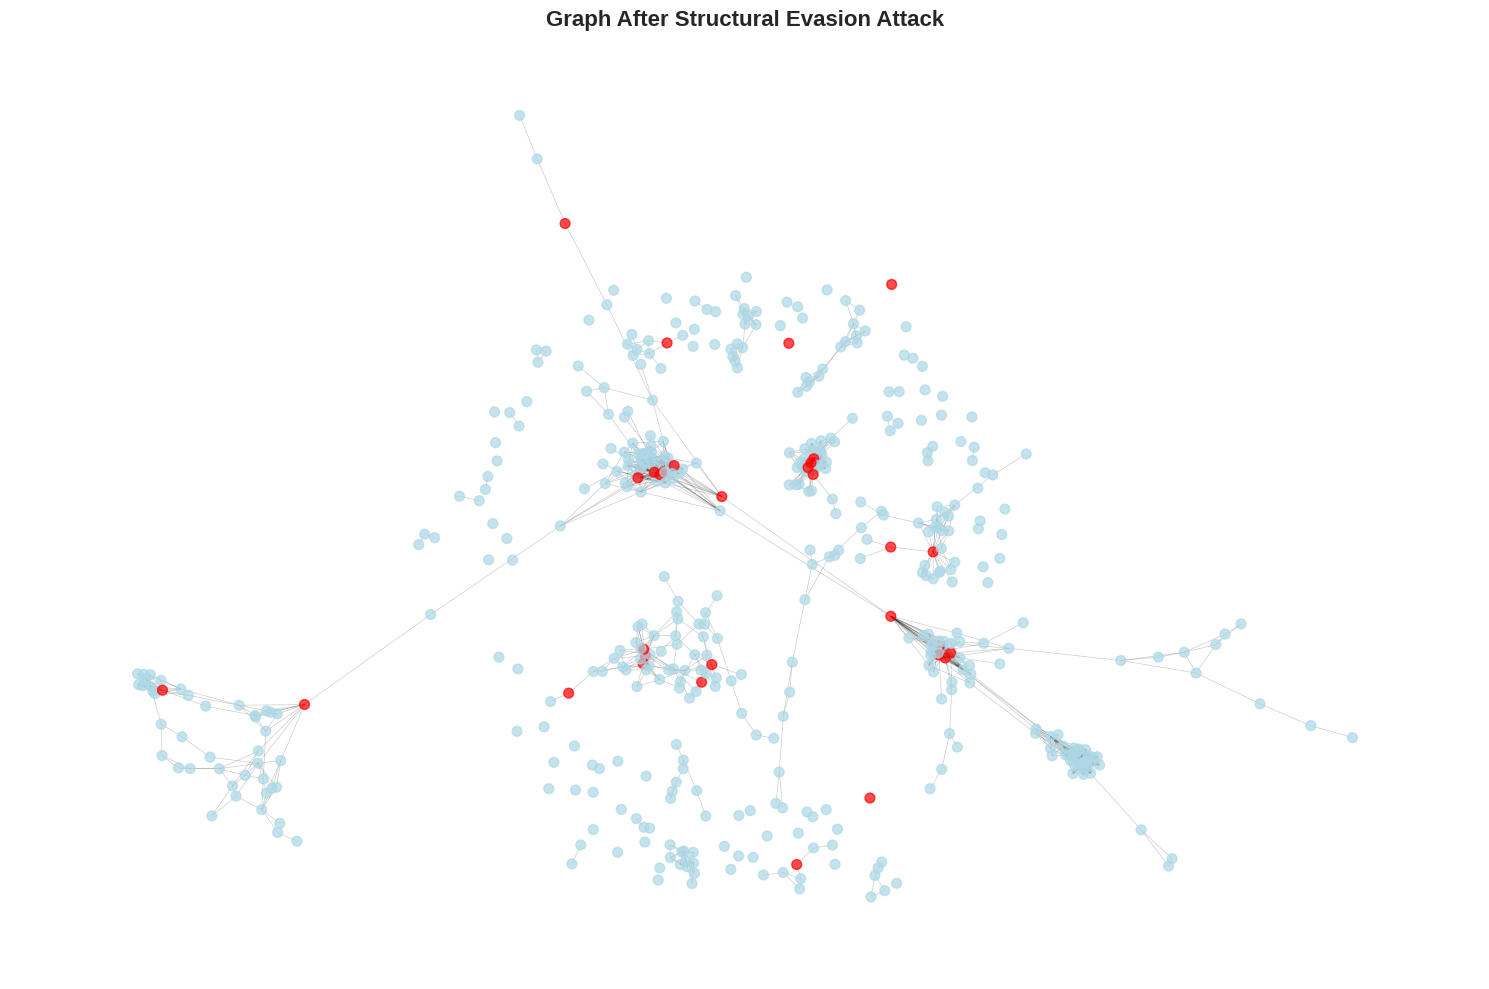

In [12]:
# ============================================================================
# CELL 12: Visualize Graph After Evasion Attack
# ============================================================================
G_sample_ev = G_evasion.subgraph(sampled_nodes).copy()
node_colors_ev = ['red' if features_df_evasion[features_df_evasion['node_id']==n]['is_bot'].values[0] == 1
                  else 'lightblue' for n in G_sample_ev.nodes() if n in features_df_evasion['node_id'].values]

plt.figure(figsize=(15, 10))
pos_ev = nx.spring_layout(G_sample_ev, k=0.5, iterations=50, seed=42)
nx.draw_networkx_nodes(G_sample_ev, pos_ev, node_color=node_colors_ev, node_size=50, alpha=0.7)
nx.draw_networkx_edges(G_sample_ev, pos_ev, alpha=0.2, width=0.5)
plt.title("Graph After Structural Evasion Attack", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('evasion_attack_graph.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# ============================================================================
# CELL 13: Graph Poisoning Attack
# ============================================================================
print("\n" + "=" * 60)
print("APPLYING GRAPH POISONING ATTACK")
print("=" * 60)

# Copy original graph for poisoning attack
G_poison = G.copy()

# Graph poisoning: Add fake legitimate nodes connected to bots
print(f"\nInjecting fake nodes to poison the graph...")

fake_nodes_added = 0
edges_added_poison = 0
fake_node_start = max(G_poison.nodes()) + 1

for bot in attacked_bots:
    # Add 2-3 fake "legitimate" nodes connected to each bot
    num_fake_nodes = np.random.randint(2, 4)

    for i in range(num_fake_nodes):
        fake_node_id = fake_node_start + fake_nodes_added
        G_poison.add_node(fake_node_id)

        # Connect fake node to bot
        G_poison.add_edge(fake_node_id, bot)
        edges_added_poison += 1

        # Connect fake node to some legitimate nodes to blend in
        num_connections = np.random.randint(3, 6)
        legitimate_targets = np.random.choice(legitimate_nodes, size=num_connections, replace=False)
        for target in legitimate_targets:
            if target in G_poison.nodes():
                G_poison.add_edge(fake_node_id, target)
                edges_added_poison += 1

        fake_nodes_added += 1

print(f"Added {fake_nodes_added} fake nodes")
print(f"Added {edges_added_poison} poisoning edges")
print(f"Graph size - Nodes before: {G.number_of_nodes()}, after: {G_poison.number_of_nodes()}")
print(f"Graph size - Edges before: {G.number_of_edges()}, after: {G_poison.number_of_edges()}")




APPLYING GRAPH POISONING ATTACK

Injecting fake nodes to poison the graph...
Added 123 fake nodes
Added 608 poisoning edges
Graph size - Nodes before: 4039, after: 4162
Graph size - Edges before: 88234, after: 88842



APPLYING SIMPLE LABEL-FLIPPING POISONING ATTACK
Flipped labels of 403 nodes (9.98%)
MODEL PERFORMANCE AFTER LABEL-FLIPPING ATTACK
Accuracy: 0.9241
Precision: 0.9375
Recall: 0.3358
F1-Score: 0.4945

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1078
           1       0.94      0.34      0.49       134

    accuracy                           0.92      1212
   macro avg       0.93      0.67      0.73      1212
weighted avg       0.93      0.92      0.91      1212



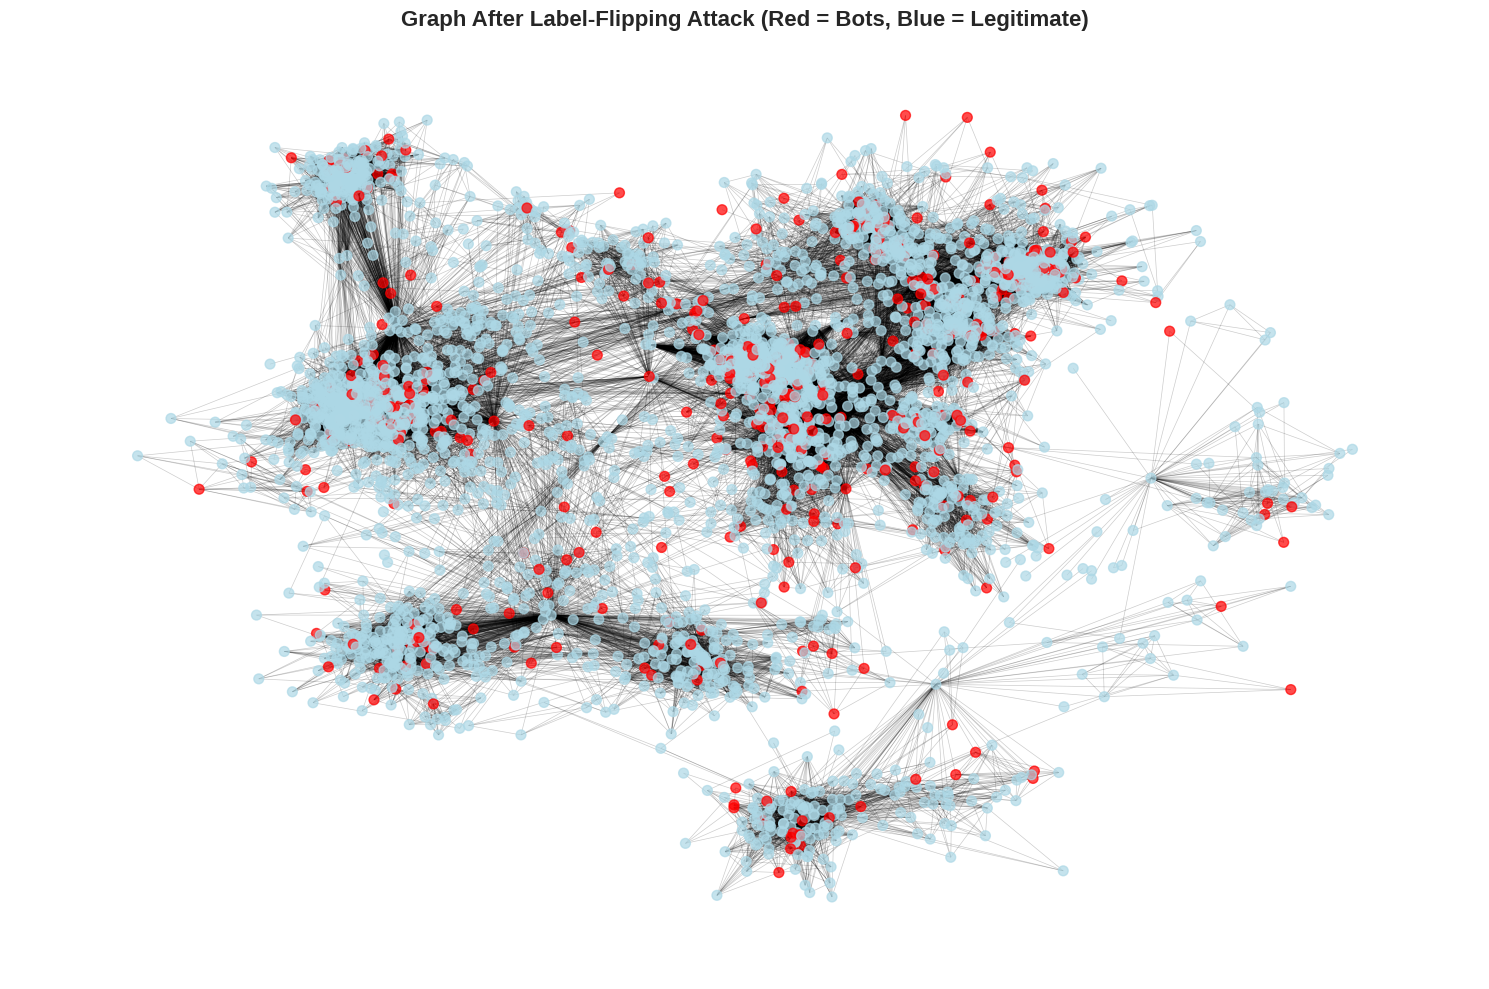

In [36]:
# ============================================================================
# CELL 13b:  Label-Flipping Poisoning Attack
# ============================================================================
print("\n" + "=" * 60)
print("APPLYING SIMPLE LABEL-FLIPPING POISONING ATTACK")
print("=" * 60)


features_df_flip = features_df.copy()


np.random.seed(42)
num_flip = int(0.1 * len(features_df_flip))
flip_indices = np.random.choice(features_df_flip.index, size=num_flip, replace=False)
features_df_flip.loc[flip_indices, 'is_bot'] = 1 - features_df_flip.loc[flip_indices, 'is_bot']

print(f"Flipped labels of {num_flip} nodes ({num_flip/len(features_df_flip)*100:.2f}%)")


X_flip = features_df_flip[['degree', 'clustering_coef', 'betweenness', 'closeness', 'pagerank']]
y_flip = features_df_flip['is_bot']


X_train_flip, X_test_flip, y_train_flip, y_test_flip = train_test_split(
    X_flip, y_flip, test_size=0.3, random_state=42, stratify=y_flip
)


flip_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
flip_model.fit(X_train_flip, y_train_flip)

# Evaluate
y_pred_flip = flip_model.predict(X_test_flip)
acc = accuracy_score(y_test_flip, y_pred_flip)
prec = precision_score(y_test_flip, y_pred_flip)
rec = recall_score(y_test_flip, y_pred_flip)
f1 = f1_score(y_test_flip, y_pred_flip)

print("=" * 60)
print("MODEL PERFORMANCE AFTER LABEL-FLIPPING ATTACK")
print("=" * 60)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_flip, y_pred_flip))

# ============================================================================
# Visualization: Graph After Label-Flipping Attack
# ============================================================================
# Assume G is your original graph (networkx Graph)
sample_size = 4039
all_nodes = list(G.nodes())
sample_nodes = np.random.choice(all_nodes, size=min(sample_size, len(all_nodes)), replace=False)
G_sample_flip = G.subgraph(sample_nodes).copy()

node_colors = []
for n in G_sample_flip.nodes():
    is_bot = features_df_flip.loc[n, 'is_bot']
    node_colors.append('red' if is_bot == 1 else 'lightblue')  # Red = bots, Blue = legitimate

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G_sample_flip, k=0.5, iterations=50, seed=42)
nx.draw_networkx_nodes(G_sample_flip, pos, node_color=node_colors, node_size=50, alpha=0.7)
nx.draw_networkx_edges(G_sample_flip, pos, alpha=0.2, width=0.5)
plt.title("Graph After Label-Flipping Attack (Red = Bots, Blue = Legitimate)", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


In [40]:
# ============================================================================
# CELL 13bb: Test Label-Flipped Model on Clean Data
# ============================================================================
print("\n" + "=" * 60)
print("TESTING LABEL-FLIPPED MODEL ON CLEAN DATA")
print("=" * 60)

# Test label-flipped model on original clean test set
y_pred_flip_on_clean = flip_model.predict(X_test)

print(f"\nAccuracy on clean data: {accuracy_score(y_test, y_pred_flip_on_clean):.4f}")
print(f"Precision on clean data: {precision_score(y_test, y_pred_flip_on_clean):.4f}")
print(f"Recall on clean data: {recall_score(y_test, y_pred_flip_on_clean):.4f}")
print(f"F1-Score on clean data: {f1_score(y_test, y_pred_flip_on_clean):.4f}")

label_flip_on_clean_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_flip_on_clean),
    'precision': precision_score(y_test, y_pred_flip_on_clean),
    'recall': recall_score(y_test, y_pred_flip_on_clean),
    'f1': f1_score(y_test, y_pred_flip_on_clean)
}



TESTING LABEL-FLIPPED MODEL ON CLEAN DATA

Accuracy on clean data: 0.9678
Precision on clean data: 0.8393
Recall on clean data: 0.6104
F1-Score on clean data: 0.7068


In [15]:
# ============================================================================
# CELL 14: Recalculate Features After Poisoning Attack
# ============================================================================
print("\nRecalculating graph features after poisoning attack...")

degree_dict_po = dict(G_poison.degree())
clustering_dict_po = nx.clustering(G_poison)
betweenness_dict_po = nx.betweenness_centrality(G_poison)
closeness_dict_po = nx.closeness_centrality(G_poison)
pagerank_dict_po = nx.pagerank(G_poison)

features_df_poison = pd.DataFrame({
    'node_id': list(G_poison.nodes()),
    'degree': [degree_dict_po[n] for n in G_poison.nodes()],
    'clustering_coef': [clustering_dict_po[n] for n in G_poison.nodes()],
    'betweenness': [betweenness_dict_po[n] for n in G_poison.nodes()],
    'closeness': [closeness_dict_po[n] for n in G_poison.nodes()],
    'pagerank': [pagerank_dict_po[n] for n in G_poison.nodes()]
})

# Assign labels: original nodes keep their labels, fake nodes are labeled as legitimate (0)
features_df_poison = features_df_poison.merge(
    features_df[['node_id', 'is_bot']], on='node_id', how='left'
)
features_df_poison['is_bot'].fillna(0, inplace=True)  # Fake nodes labeled as legitimate
features_df_poison['is_bot'] = features_df_poison['is_bot'].astype(int)



Recalculating graph features after poisoning attack...


In [16]:
# ============================================================================
# CELL 15: Evaluate Model After Poisoning Attack
# ============================================================================
X_poison = features_df_poison[['degree', 'clustering_coef', 'betweenness', 'closeness', 'pagerank']]
y_poison = features_df_poison['is_bot']

# Split with stratification
X_train_po, X_test_po, y_train_po, y_test_po = train_test_split(
    X_poison, y_poison, test_size=0.3, random_state=42, stratify=y_poison
)

# Train new model on poisoned data
poisoned_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
poisoned_model.fit(X_train_po, y_train_po)

# Evaluate on poisoned test set
y_pred_poison = poisoned_model.predict(X_test_po)

print("=" * 60)
print("MODEL PERFORMANCE AFTER GRAPH POISONING ATTACK")
print("=" * 60)
print(f"\nAccuracy: {accuracy_score(y_test_po, y_pred_poison):.4f}")
print(f"Precision: {precision_score(y_test_po, y_pred_poison, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test_po, y_pred_poison, zero_division=0):.4f}")
print(f"F1-Score: {f1_score(y_test_po, y_pred_poison, zero_division=0):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_po, y_pred_poison, zero_division=0))

poison_metrics = {
    'accuracy': accuracy_score(y_test_po, y_pred_poison),
    'precision': precision_score(y_test_po, y_pred_poison, zero_division=0),
    'recall': recall_score(y_test_po, y_pred_poison, zero_division=0),
    'f1': f1_score(y_test_po, y_pred_poison, zero_division=0)
}


MODEL PERFORMANCE AFTER GRAPH POISONING ATTACK

Accuracy: 0.9808
Precision: 0.9818
Recall: 0.7013
F1-Score: 0.8182

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1172
           1       0.98      0.70      0.82        77

    accuracy                           0.98      1249
   macro avg       0.98      0.85      0.90      1249
weighted avg       0.98      0.98      0.98      1249



In [17]:
# ============================================================================
# CELL 16: Test Poisoned Model on Clean Data
# ============================================================================
print("\n" + "=" * 60)
print("TESTING POISONED MODEL ON CLEAN DATA")
print("=" * 60)

# Test poisoned model on original clean test set
y_pred_poison_on_clean = poisoned_model.predict(X_test)

print(f"\nAccuracy on clean data: {accuracy_score(y_test, y_pred_poison_on_clean):.4f}")
print(f"Precision on clean data: {precision_score(y_test, y_pred_poison_on_clean):.4f}")
print(f"Recall on clean data: {recall_score(y_test, y_pred_poison_on_clean):.4f}")
print(f"F1-Score on clean data: {f1_score(y_test, y_pred_poison_on_clean):.4f}")

poison_on_clean_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_poison_on_clean),
    'precision': precision_score(y_test, y_pred_poison_on_clean),
    'recall': recall_score(y_test, y_pred_poison_on_clean),
    'f1': f1_score(y_test, y_pred_poison_on_clean)
}



TESTING POISONED MODEL ON CLEAN DATA

Accuracy on clean data: 0.9728
Precision on clean data: 0.9783
Recall on clean data: 0.5844
F1-Score on clean data: 0.7317


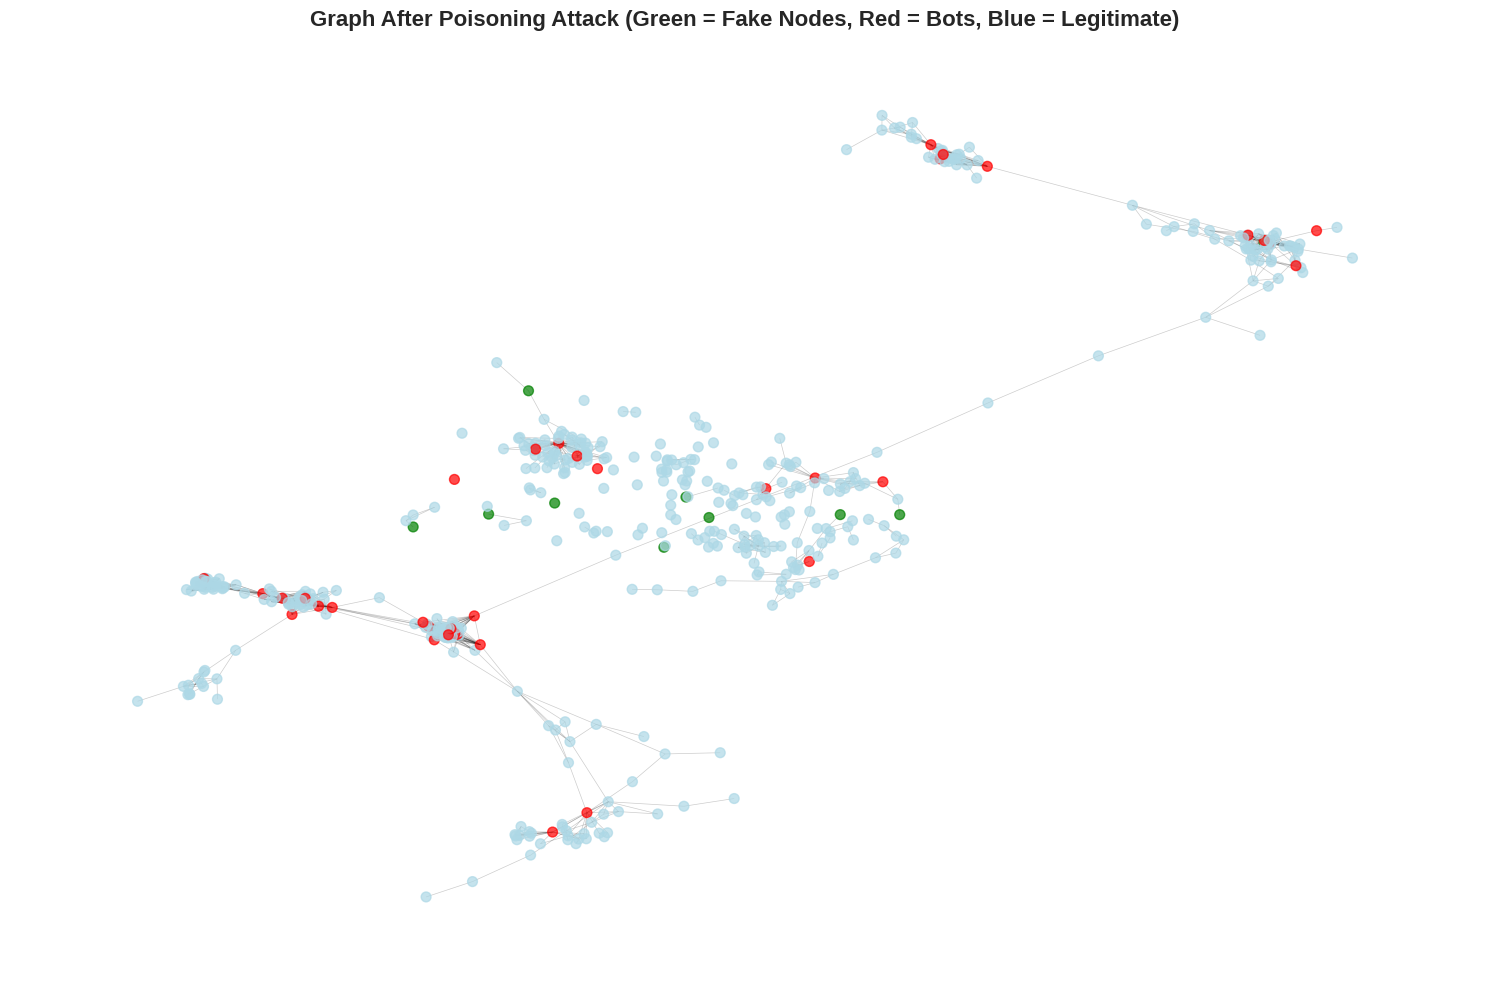

In [18]:
# ============================================================================
# CELL 17: Visualize Graph After Poisoning Attack
# ============================================================================
# Sample nodes including some fake nodes
all_nodes_poison = list(G_poison.nodes())
sample_poison = np.random.choice(all_nodes_poison, size=min(sample_size, len(all_nodes_poison)), replace=False)
G_sample_po = G_poison.subgraph(sample_poison).copy()

node_colors_po = []
for n in G_sample_po.nodes():
    if n in features_df_poison['node_id'].values:
        is_bot = features_df_poison[features_df_poison['node_id']==n]['is_bot'].values[0]
        is_fake = n >= fake_node_start
        if is_fake:
            node_colors_po.append('green')  # Fake nodes
        elif is_bot == 1:
            node_colors_po.append('red')  # Bots
        else:
            node_colors_po.append('lightblue')  # Legitimate

plt.figure(figsize=(15, 10))
pos_po = nx.spring_layout(G_sample_po, k=0.5, iterations=50, seed=42)
nx.draw_networkx_nodes(G_sample_po, pos_po, node_color=node_colors_po, node_size=50, alpha=0.7)
nx.draw_networkx_edges(G_sample_po, pos_po, alpha=0.2, width=0.5)
plt.title("Graph After Poisoning Attack (Green = Fake Nodes, Red = Bots, Blue = Legitimate)",
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('poisoning_attack_graph.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# ============================================================================
# CELL 18: Compare Performance Across All Scenarios
# ============================================================================
print("\n" + "=" * 60)
print("PERFORMANCE COMPARISON ACROSS ALL SCENARIOS")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Scenario': ['Baseline (No Attack)', 'Structural Evasion', 'Graph Poisoning', 'Poisoned Model on Clean Data'],
    'Accuracy': [baseline_metrics['accuracy'], evasion_metrics['accuracy'],
                 poison_metrics['accuracy'], poison_on_clean_metrics['accuracy']],
    'Precision': [baseline_metrics['precision'], evasion_metrics['precision'],
                  poison_metrics['precision'], poison_on_clean_metrics['precision']],
    'Recall': [baseline_metrics['recall'], evasion_metrics['recall'],
               poison_metrics['recall'], poison_on_clean_metrics['recall']],
    'F1-Score': [baseline_metrics['f1'], evasion_metrics['f1'],
                 poison_metrics['f1'], poison_on_clean_metrics['f1']]
})

print("\n", comparison_df.to_string(index=False))


PERFORMANCE COMPARISON ACROSS ALL SCENARIOS

                     Scenario  Accuracy  Precision   Recall  F1-Score
        Baseline (No Attack)  0.971122   0.977273 0.558442  0.710744
          Structural Evasion  0.974422   0.979167 0.610390  0.752000
             Graph Poisoning  0.980785   0.981818 0.701299  0.818182
Poisoned Model on Clean Data  0.972772   0.978261 0.584416  0.731707


In [21]:
# ============================================================================
# CELL 20: Graph Structure Impact Analysis
# ============================================================================
print("\n" + "=" * 60)
print("GRAPH STRUCTURE IMPACT ANALYSIS")
print("=" * 60)

structure_comparison = pd.DataFrame({
    'Metric': ['Nodes', 'Edges', 'Density', 'Avg Degree', 'Avg Clustering'],
    'Baseline': [
        G.number_of_nodes(),
        G.number_of_edges(),
        nx.density(G),
        np.mean([d for n, d in G.degree()]),
        np.mean(list(nx.clustering(G).values()))
    ],
    'After Evasion': [
        G_evasion.number_of_nodes(),
        G_evasion.number_of_edges(),
        nx.density(G_evasion),
        np.mean([d for n, d in G_evasion.degree()]),
        np.mean(list(nx.clustering(G_evasion).values()))
    ],
    'After Poisoning': [
        G_poison.number_of_nodes(),
        G_poison.number_of_edges(),
        nx.density(G_poison),
        np.mean([d for n, d in G_poison.degree()]),
        np.mean(list(nx.clustering(G_poison).values()))
    ]
})

print("\n", structure_comparison.to_string(index=False))



GRAPH STRUCTURE IMPACT ANALYSIS

         Metric     Baseline  After Evasion  After Poisoning
         Nodes  4039.000000    4039.000000      4162.000000
         Edges 88234.000000   88432.000000     88842.000000
       Density     0.010820       0.010844         0.010260
    Avg Degree    43.691013      43.789057        42.691975
Avg Clustering     0.605547       0.597971         0.576250


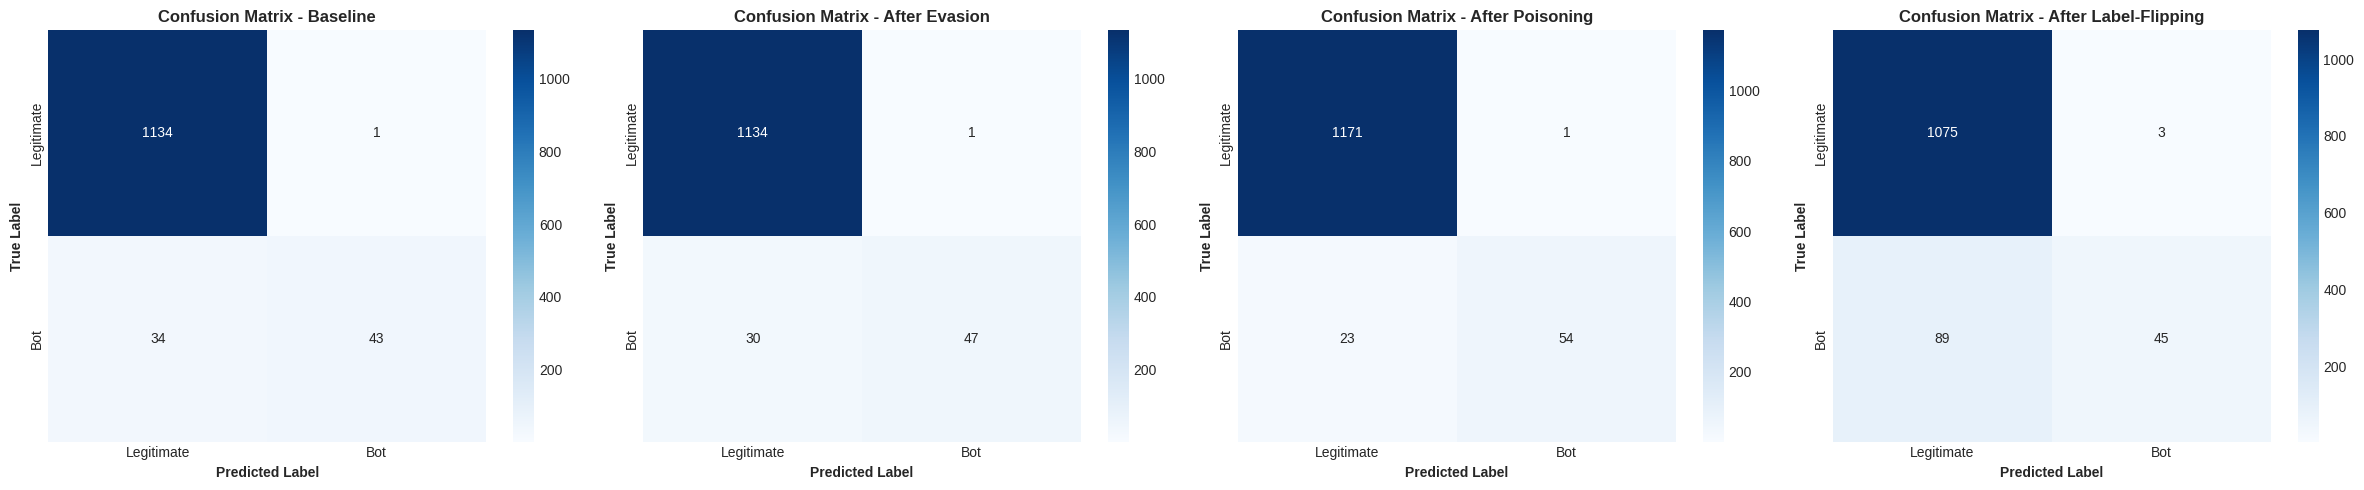

In [46]:
# ============================================================================
# CELL 22b: Confusion Matrices (Including Label-Flipping Attack)
# ============================================================================

fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# List of scenarios: (Title, True Labels, Predicted Labels)
scenarios = [
    ('Baseline', y_test, y_pred_baseline),
    ('After Evasion', y_test_ev, y_pred_evasion),
    ('After Poisoning', y_test_po, y_pred_poison),
    ('After Label-Flipping', y_test_flip, y_pred_flip)
]

for idx, (title, y_true, y_pred) in enumerate(scenarios):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Legitimate', 'Bot'], yticklabels=['Legitimate', 'Bot'])
    axes[idx].set_title(f'Confusion Matrix - {title}', fontweight='bold')
    axes[idx].set_ylabel('True Label', fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices_all_attacks.png', dpi=300, bbox_inches='tight')
plt.show()



FEATURE IMPORTANCE ANALYSIS

Baseline Model Feature Importance:
1. pagerank: 0.3110
2. degree: 0.2290
3. clustering_coef: 0.2176
4. closeness: 0.1313
5. betweenness: 0.1111


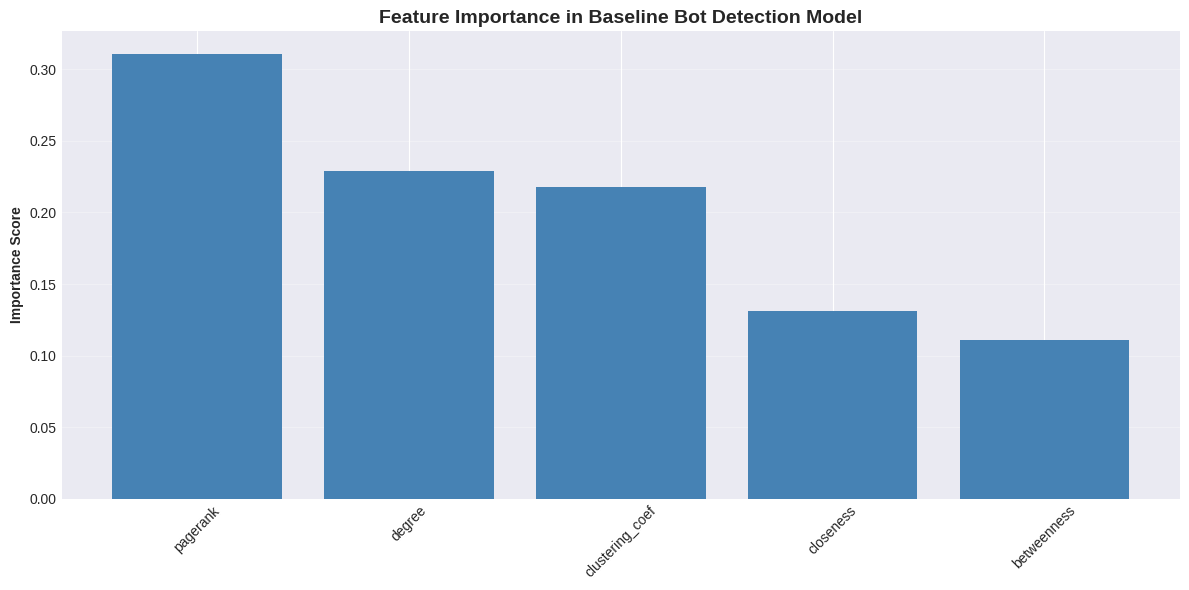


Poisoned Model Feature Importance:
1. pagerank: 0.2804
2. degree: 0.2254
3. clustering_coef: 0.2559
4. closeness: 0.1479
5. betweenness: 0.0904


In [26]:
# ============================================================================
# CELL 25: Feature Importance Analysis
# ============================================================================
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importance from baseline model
feature_names = ['degree', 'clustering_coef', 'betweenness', 'closeness', 'pagerank']
importances_baseline = baseline_model.feature_importances_

# Sort by importance
indices = np.argsort(importances_baseline)[::-1]

print("\nBaseline Model Feature Importance:")
for i, idx in enumerate(indices):
    print(f"{i+1}. {feature_names[idx]}: {importances_baseline[idx]:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances_baseline)), importances_baseline[indices], color='steelblue')
plt.xticks(range(len(importances_baseline)), [feature_names[i] for i in indices], rotation=45)
plt.ylabel('Importance Score', fontweight='bold')
plt.title('Feature Importance in Baseline Bot Detection Model', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare feature importance after poisoning
importances_poisoned = poisoned_model.feature_importances_
print("\nPoisoned Model Feature Importance:")
for i, idx in enumerate(indices):
    print(f"{i+1}. {feature_names[idx]}: {importances_poisoned[idx]:.4f}")

In [31]:
# ============================================================================
# CELL 30: Export Results and Generate Report Data
# ============================================================================
print("\n" + "=" * 60)
print("EXPORTING RESULTS")
print("=" * 60)

# Save all metrics to CSV
comparison_df.to_csv('performance_comparison.csv', index=False)
print("✓ Saved: performance_comparison.csv")

structure_comparison.to_csv('graph_structure_comparison.csv', index=False)
print("✓ Saved: graph_structure_comparison.csv")

# Save feature data
features_df.to_csv('baseline_features.csv', index=False)
features_df_evasion.to_csv('evasion_features.csv', index=False)
features_df_poison.to_csv('poisoning_features.csv', index=False)
print("✓ Saved: baseline_features.csv, evasion_features.csv, poisoning_features.csv")

# Create comprehensive report dictionary
report_data = {
    'experiment_info': {
        'dataset': 'Facebook Social Network (SNAP)',
        'total_nodes': G.number_of_nodes(),
        'total_edges': G.number_of_edges(),
        'bot_percentage': f"{features_df['is_bot'].mean()*100:.2f}%"
    },
    'baseline_performance': baseline_metrics,
    'evasion_attack': {
        'performance': evasion_metrics,
        'edges_added': edges_added,
        'bots_attacked': num_bots_to_attack
    },
    'poisoning_attack': {
        'performance': poison_metrics,
        'performance_on_clean': poison_on_clean_metrics,
        'fake_nodes_added': fake_nodes_added,
        'edges_added': edges_added_poison,
        'bots_attacked': num_bots_to_attack
    },
    'key_findings': {
        'evasion_f1_drop': f"{baseline_metrics['f1'] - evasion_metrics['f1']:.4f}",
        'poisoning_f1_drop': f"{baseline_metrics['f1'] - poison_metrics['f1']:.4f}",
        'most_effective_attack': 'Evasion' if abs(baseline_metrics['f1'] - evasion_metrics['f1']) > abs(baseline_metrics['f1'] - poison_metrics['f1']) else 'Poisoning'
    }
}

# Save report data as JSON
import json
with open('report_data.json', 'w') as f:
    json.dump(report_data, f, indent=4)
print("✓ Saved: report_data.json")

print("\n" + "=" * 60)
print("ALL VISUALIZATIONS AND DATA EXPORTED SUCCESSFULLY")
print("=" * 60)
print("\nGenerated Files:")
print("  Images:")
print("    - baseline_graph.png")
print("    - evasion_attack_graph.png")
print("    - poisoning_attack_graph.png")
print("    - performance_comparison.png")
print("    - feature_distributions.png")
print("    - confusion_matrices.png")
print("    - feature_importance.png")
print("    - bot_vs_legitimate_comparison.png")
print("    - degree_distributions.png")
print("    - attack_impact_visualization.png")
print("  Data:")
print("    - performance_comparison.csv")
print("    - graph_structure_comparison.csv")
print("    - baseline_features.csv")
print("    - evasion_features.csv")
print("    - poisoning_features.csv")
print("    - report_data.json")

print("\n" + "=" * 60)
print("ASSIGNMENT COMPLETE!")
print("=" * 60)


EXPORTING RESULTS
✓ Saved: performance_comparison.csv
✓ Saved: graph_structure_comparison.csv
✓ Saved: baseline_features.csv, evasion_features.csv, poisoning_features.csv
✓ Saved: report_data.json

ALL VISUALIZATIONS AND DATA EXPORTED SUCCESSFULLY

Generated Files:
  Images:
    - baseline_graph.png
    - evasion_attack_graph.png
    - poisoning_attack_graph.png
    - performance_comparison.png
    - feature_distributions.png
    - confusion_matrices.png
    - feature_importance.png
    - bot_vs_legitimate_comparison.png
    - degree_distributions.png
    - attack_impact_visualization.png
  Data:
    - performance_comparison.csv
    - graph_structure_comparison.csv
    - baseline_features.csv
    - evasion_features.csv
    - poisoning_features.csv
    - report_data.json

ASSIGNMENT COMPLETE!
